In [191]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [192]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [193]:
len(words)

32033

In [194]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [195]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
    X, Y = [], []
  
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [196]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Added operation to bring values closer to 0 at initialization.
# Preactivations being too high can cause squashing function to
# squash the values to -1 or 1, essentially making the nodes passthrough
# and killing their ability to learn.
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) # on initialize, multiply by (gain / sqrt(fan_in)) https://pytorch.org/docs/stable/nn.init.html # kaiming_normal
# b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

12097


In [197]:
# same optimization as last time
max_steps = 20000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    #track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())
    
    #break

      0/  20000: 3.3239
  10000/  20000: 2.0322


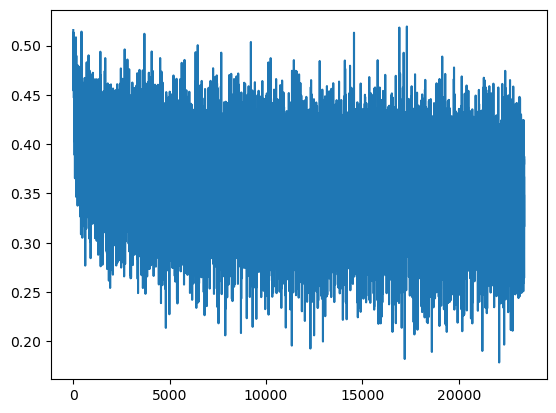

In [148]:
plt.plot(lossi)

In [187]:
# calibrate the batch norm at the end of training

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 # + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [188]:
bnmean

tensor([[-1.5816e+00,  1.6654e-02, -1.1374e+00,  9.2894e-01,  7.3143e-01,
          2.3539e-01,  1.2082e+00, -4.0648e-01,  3.2103e-01,  1.0803e+00,
         -1.3943e+00, -1.5936e+00, -4.1541e-01, -4.1030e-01,  2.0321e-02,
          3.4265e-01,  4.5872e-01, -1.5634e+00, -6.3642e-01,  9.0305e-01,
          2.7461e-01, -2.1992e-01, -4.6876e-02,  4.9438e-01,  7.3139e-01,
          8.1352e-01,  9.7980e-01, -1.5089e-01,  6.7362e-02,  1.0590e+00,
         -4.7869e-01, -7.9198e-01,  2.9008e-01,  2.3689e-01, -2.4722e-01,
         -8.6839e-01, -1.2301e+00, -1.9248e-01, -2.0647e-01,  3.3977e-01,
         -2.1474e-01, -8.8541e-01, -5.4856e-01,  2.6787e-01,  3.5080e-01,
         -1.2032e-01,  6.3036e-01, -1.5975e-01,  8.6124e-01,  1.2225e+00,
          6.7260e-01,  1.0967e-01,  1.2015e+00,  1.0524e+00,  7.6517e-01,
         -1.4524e+00, -1.7019e-01,  5.2047e-01,  1.2758e+00, -7.8020e-01,
         -6.8363e-01,  4.2255e-01,  2.1357e-01,  1.6803e-01,  1.1221e+00,
          6.6143e-01,  1.1037e-02,  6.

In [189]:
bnmean_running

tensor([[-1.5413,  0.0270, -1.1268,  0.8980,  0.7018,  0.2189,  1.2349, -0.3846,
          0.3153,  1.0361, -1.3514, -1.5733, -0.3636, -0.4014,  0.0307,  0.3009,
          0.4725, -1.5595, -0.5959,  0.8794,  0.2503, -0.2356, -0.0641,  0.4943,
          0.7101,  0.7979,  0.8648, -0.1771,  0.0318,  1.0807, -0.4643, -0.7873,
          0.2704,  0.2118, -0.2343, -0.8355, -1.2030, -0.2253, -0.2083,  0.3567,
         -0.2270, -0.8897, -0.5540,  0.2448,  0.3582, -0.1334,  0.5680, -0.2407,
          0.7947,  1.2338,  0.6386,  0.1061,  1.1941,  1.0682,  0.7372, -1.4596,
         -0.2032,  0.4971,  1.3082, -0.7659, -0.6854,  0.4371,  0.2263,  0.1735,
          1.1189,  0.6687, -0.0409,  0.6519, -0.5306, -0.5528,  0.0604,  0.6909,
          0.4991, -1.0533, -1.6523, -0.1363,  0.8948, -0.0478,  0.3362,  0.6754,
          0.3787,  1.0693,  0.7667,  0.5532,  0.3055, -0.4417, -0.8841,  0.2934,
          0.2917, -0.1232, -0.7294,  0.9458, -0.2254, -0.4043, -0.5780,  0.2446,
         -0.4172, -0.0829,  

In [118]:
@torch.no_grad() # this decorator disables gradient tracking -- improves efficiency when .backward is not going to be called
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 # hidden layer pre-activation
    # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
    h = torch.tanh(embcat @ W1) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.3605451583862305
val 2.4363131523132324


In [64]:
# sample from model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1,block_size,n_embd)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

carmah.
ambrie.
khy.
mili.
tatyanna.
sane.
rahnie.
delynn.
jareei.
ner.
kiah.
maiha.
kaleigh.
ham.
jois.
quint.
sulie.
alianni.
wanell.
dearynn.
